# Table of Contents

* <a href='#1'>1. Prerequisites</a>  
  - <a href='#11'>1.1. Load Libraries</a>  
  - <a href='#12'>1.2. Settings And Global Variables</a>
  - <a href='#13'>1.3. Load Data</a>
* <a href='#2'>2. Time Series Analysis</a>
  - <a href='#21'>2.1. Time Series Visualization</a>
    + <a href='#211'>2.1.1. Project Posted vs. Expired Date</a>
    + <a href='#212'>2.1.2. Project Fully Funded Date</a>
    + <a href='#213'>2.1.3. Teacher First Project Posted Date</a>
    + <a href='#214'>2.1.4. Donations</a>
      - <a href='#2141'>2.1.4.1. Donation Amounts and Counts</a>
      - <a href='#2142'>2.1.4.2. Donation Counts and Average by Month</a>
      - <a href='#2143'>2.1.4.3. Donation Counts and Average by Weekday</a>
    + <a href='#215'>2.1.5. Trend of Donations Among States</a>
    + <a href='#216'>2.1.6. Trend of Top 10 Cities of Donations</a>
  - <a href='#22'>2.2. Time Series Modeling</a>
    + <a href='#221'>2.2.1. Trend of Project Posted Counts</a>
    + <a href='#222'>2.2.2. Trend of Project Expiration Counts</a>
    + <a href='#223'>2.2.3. Trend of First Posted Project</a>
    + <a href='#224'>2.2.4. Trend of Donation Amounts</a>

# <a id='1'>1. Prerequisites</a>

## <a id='11'>1.1 Load Libraries</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as offline
offline.init_notebook_mode(connected=True)

import plotly.graph_objs as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import gc
import time

Using TensorFlow backend.


## <a id='12'>1.2. Settings And Global Variables</a>

In [2]:
# Data directory
data_dir = './input/'
sns.set()

## <a id='13'>1.3. Load Data</a>

In [3]:
donations = pd.read_csv(data_dir+"Donations.csv",error_bad_lines=False)
projects = pd.read_csv(data_dir+"Projects.csv",error_bad_lines=False)
donors = pd.read_csv(data_dir+"Donors.csv",error_bad_lines=False)
resources = pd.read_csv(data_dir+"Resources.csv",error_bad_lines=False)
schools = pd.read_csv(data_dir+"Schools.csv",error_bad_lines=False)
teachers = pd.read_csv(data_dir+"Teachers.csv",error_bad_lines=False)

/homes/li2566/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning:

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.



# <a id='2'>2. Time Series Analysis</a>

The raw data contains time data like `Donation Received Date`,`Project Expiration Date`, etc. We will apply some time series analysis techniques and try to analyze the time series with statistical models.

## <a id='21'>2.1. Time Series Visualization</a>

Before analyzing the time series, let's visualize it for better intuition.

### <a id='211'>2.1.1. Project Posted vs. Expired Date</a>

Text(0.5,1,'Trend of Posted and Expired Projects')

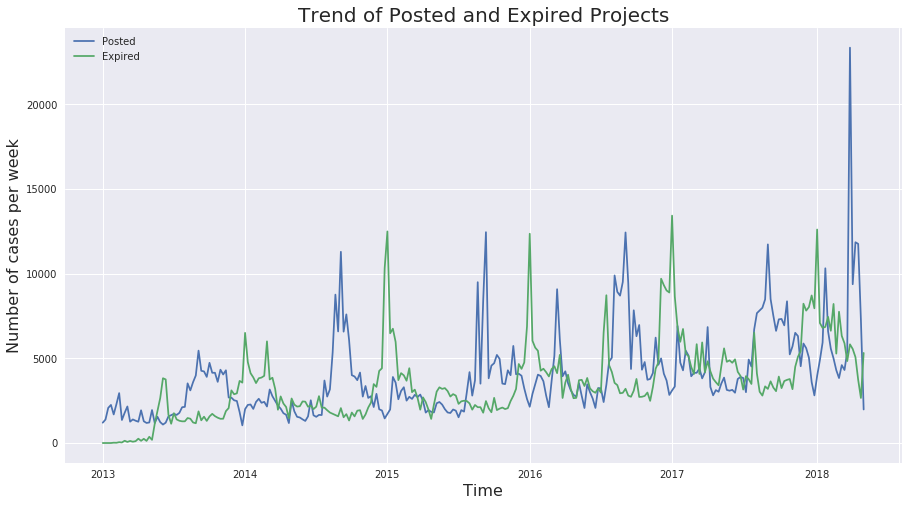

In [4]:
left = pd.to_datetime(projects['Project Posted Date']).to_frame()
left.loc[:,'posted_count'] = 1
left.sort_values(by='Project Posted Date',inplace=True)
left.set_index(keys='Project Posted Date',inplace=True)
left = left.resample('W').count()
left.set_index(left.index.to_period(freq='W'),inplace=True)

right = pd.to_datetime(projects['Project Expiration Date']).to_frame()
right.loc[:,'expired_count'] = 1
right.sort_values(by='Project Expiration Date',inplace=True)
right.set_index(keys='Project Expiration Date',inplace=True)
right = right.resample('W').count()
right.set_index(right.index.to_period(freq='W'),inplace=True)

merged = left.merge(right,left_index=True,right_index=True)
merged.head()
merged.plot(figsize=(15,8))
plt.xlabel('Time',fontsize=16)
plt.ylabel('Number of cases per week',fontsize=16)
plt.legend(['Posted','Expired'])
plt.title("Trend of Posted and Expired Projects",fontsize=20)

We learn clear seasonalities for both posted and expired projects, and we see the expired pattern is like a shifted one of posted. We will analyze it later.

### <a id='212'>2.1.2. Project Fully Funded Date</a>

Text(0.5,1,'Trend of Fully Funded Projects')

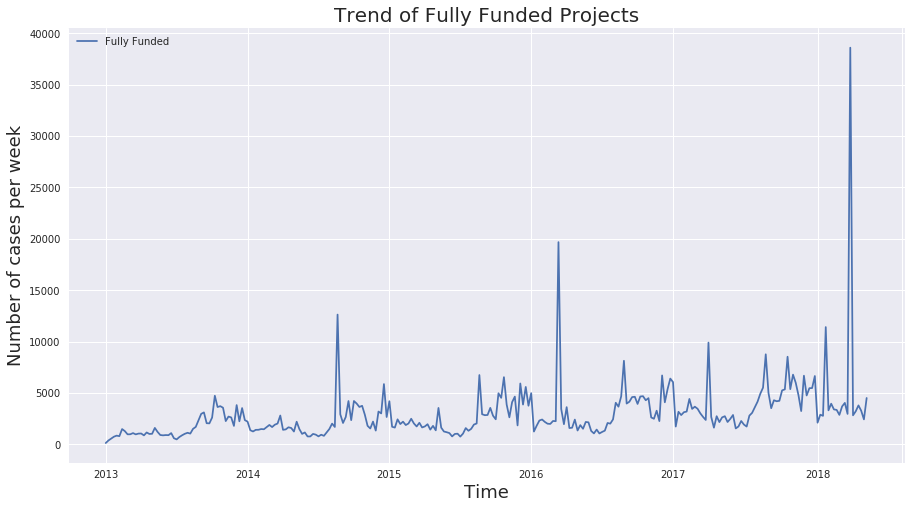

In [5]:
temp = pd.to_datetime(projects['Project Fully Funded Date']).to_frame()
temp.loc[:,'count'] = 1
temp.sort_values(by='Project Fully Funded Date',inplace=True)
temp.set_index(keys='Project Fully Funded Date',inplace=True)
temp = temp.resample('W').count()
temp.set_index(temp.index.to_period(freq='W'),inplace=True)
temp.plot(figsize=(15,8))
plt.xlabel('Time',fontsize=18)
plt.ylabel('Number of cases per week',fontsize=18)
plt.legend(['Fully Funded'])
plt.title("Trend of Fully Funded Projects",fontsize=20)

Although not obvious, there exists some seasonality in the series.

### <a id='213'>2.1.3. Teacher First Project Posted Date</a>

Text(0.5,1,'Trend of Teacher First Project Posted Date')

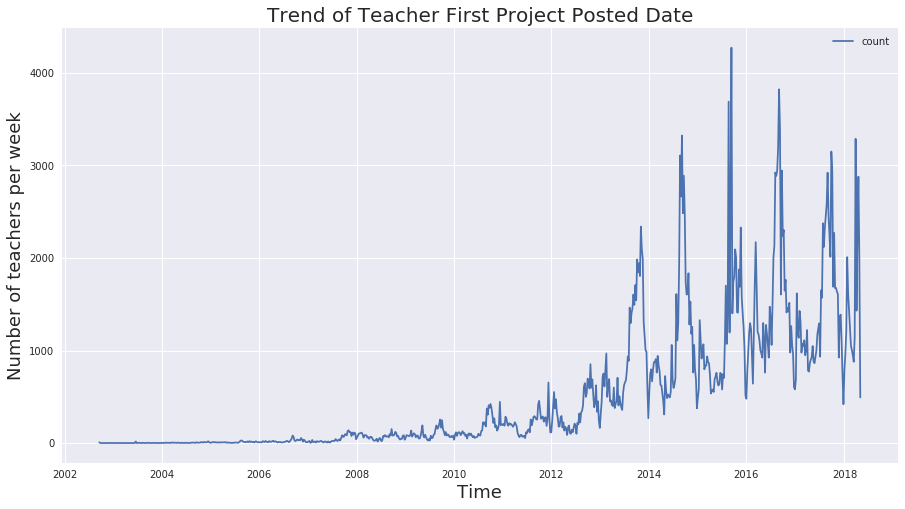

In [6]:
temp = pd.to_datetime(teachers['Teacher First Project Posted Date']).to_frame()
temp.loc[:,'count'] = 1
temp.sort_values(by='Teacher First Project Posted Date',inplace=True)
temp.set_index(keys='Teacher First Project Posted Date',inplace=True)
#temp.head()
temp = temp.resample('W').count()
temp.set_index(temp.index.to_period(freq='W'),inplace=True)
temp.plot(figsize=(15,8))
plt.xlabel('Time',fontsize=18)
plt.ylabel('Number of teachers per week',fontsize=18)
plt.title("Trend of Teacher First Project Posted Date",fontsize=20)

As we expect, the number of teachers involved in DonorsChoose is increasing each year.

### <a id='214'>2.1.4. Donations</a>

We assume **Donation Received Date** is the actual donation, although they should be very close.

### <a id='2141'>2.1.4.1. Donation Amounts and Counts</a>

In [7]:
temp = donations.loc[:,['Donation Amount','Donation Received Date']]
temp.loc[:,'Donation Received Date'] = pd.to_datetime(temp['Donation Received Date'])
temp.sort_values(by='Donation Received Date',inplace=True)
temp.set_index(keys='Donation Received Date',inplace=True)
temp = temp.resample('W').agg(['sum','count'])
temp.set_index(temp.index.to_period(freq='W'),inplace=True)
temp.columns = temp.columns.droplevel(0)

For the number of donations, the trend is increasing, while there is no significant trend for average amount of donations.

Text(0.5,1,'Trend of Donations Amounts')

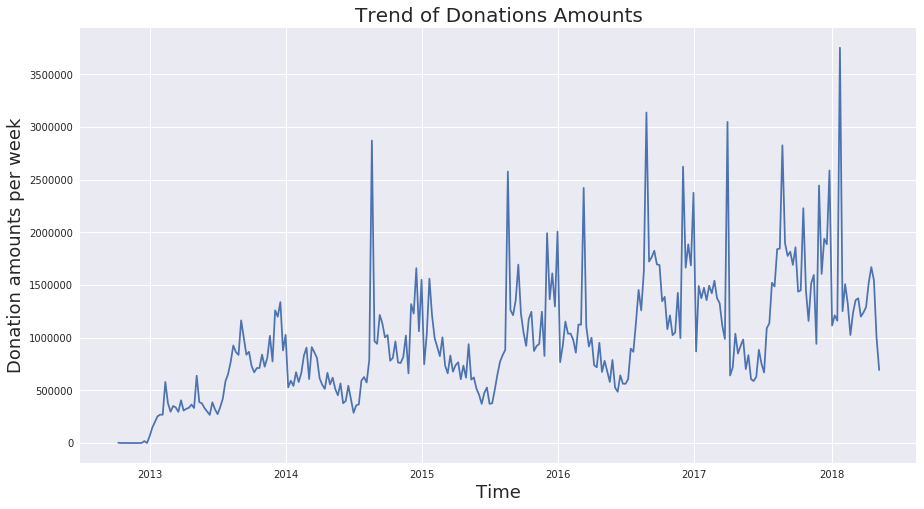

In [8]:
ax1 = temp['sum'].plot(figsize=(15,8))
plt.xlabel('Time',fontsize=18)
plt.ylabel('Donation amounts per week',fontsize=18)
plt.title("Trend of Donations Amounts",fontsize=20)

Text(0.5,1,'Trend of Donations Counts')

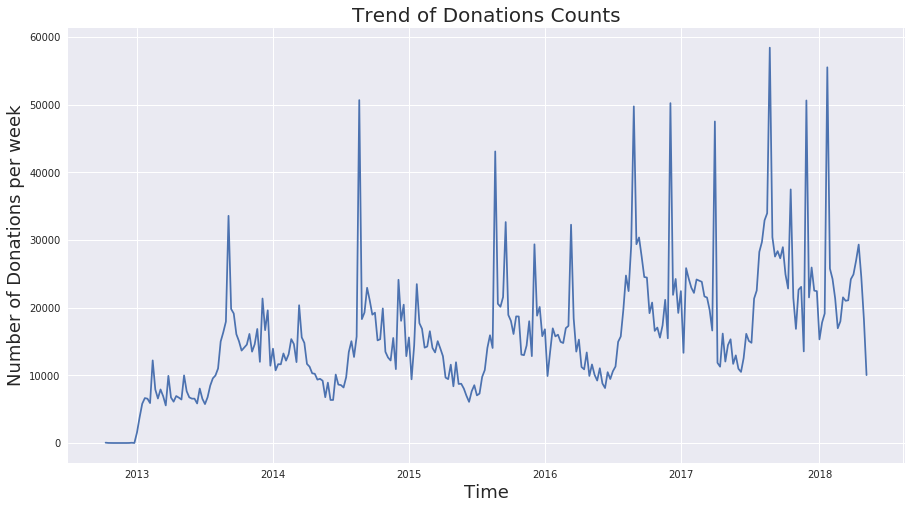

In [9]:
ax1 = temp['count'].plot(figsize=(15,8))
plt.xlabel('Time',fontsize=18)
plt.ylabel('Number of Donations per week',fontsize=18)
plt.title("Trend of Donations Counts",fontsize=20)

### <a id='2142'>2.1.4.2. Donation Counts and Average by Month</a>

Just in case, we do some summaries of donation by month and weekdays.

/homes/li2566/.local/lib/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/homes/li2566/.local/lib/python2.7/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



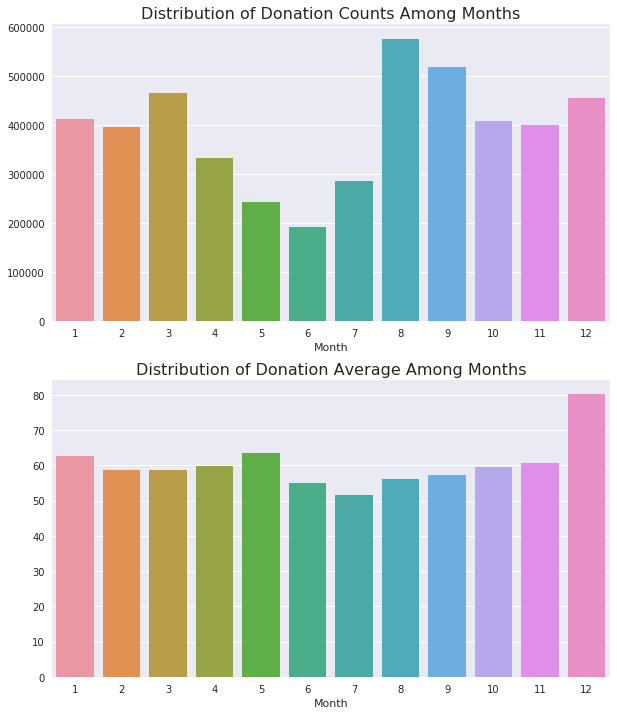

In [10]:
temp = donations[['Donation Amount','Donation Received Date']]
temp.loc[:,'Donation Received Date'] = pd.to_datetime(temp['Donation Received Date'])
temp.loc[:,'Month'] = temp['Donation Received Date'].dt.month
count_mean = temp.groupby('Month')['Donation Amount'].agg(['count','mean']).sort_index()
count_mean.rename(columns={'count':'Counts','mean':'Average'},inplace=True)
fig = plt.figure(figsize=(10,12))
for idx,col in enumerate(count_mean.columns):
    ax = fig.add_subplot(int(str(21)+str(idx+1)))
    sns.barplot(x=count_mean.index,y=col,data=count_mean,ax=ax)
    ax.set_title("Distribution of Donation {} Among Months".format(col),fontsize=16)
    plt.ylabel("")

### <a id='2143'>2.1.4.3. Donation Counts and Average by Weekday</a>

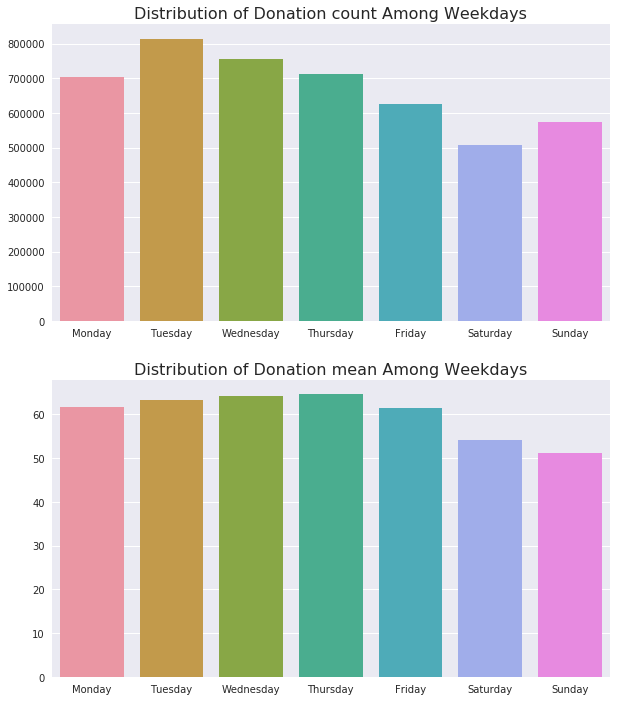

In [11]:
temp = donations[['Donation Amount','Donation Received Date']]
temp.loc[:,'Donation Received Date'] = pd.to_datetime(temp['Donation Received Date'])
temp.loc[:,'Month'] = temp['Donation Received Date'].dt.weekday
count_mean = temp.groupby('Month')['Donation Amount'].agg(['count','mean']).sort_index()
count_mean.rename(columns={'count':'Counts','mean':'Average'})
count_mean.rename(index={0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'},inplace=True)
fig = plt.figure(figsize=(10,12))
for idx,col in enumerate(count_mean.columns):
    ax = fig.add_subplot(int(str(21)+str(idx+1)))
    sns.barplot(count_mean.index,count_mean[col],ax=ax)
    ax.set_title("Distribution of Donation {} Among Weekdays".format(col),fontsize=16)
    plt.ylabel("")
    plt.xlabel("")

From the above figures, we learn that the number of donations decreases in the period from June to July, which coincides with the summer section. As to the weeksays we didn't see any noticeable trend.

## <a id='22'>2.2. Time Series Modeling</a>

In this section, we will try ARIMA and LSTM to model the time series.

### <a id='221'>2.2.1. Trend of Project Posted Counts</a>

Here we will try to fit ARIMA model to the number of posted projects as a time series. let's get some intuition by plotting the series.

Text(0.5,0,'')

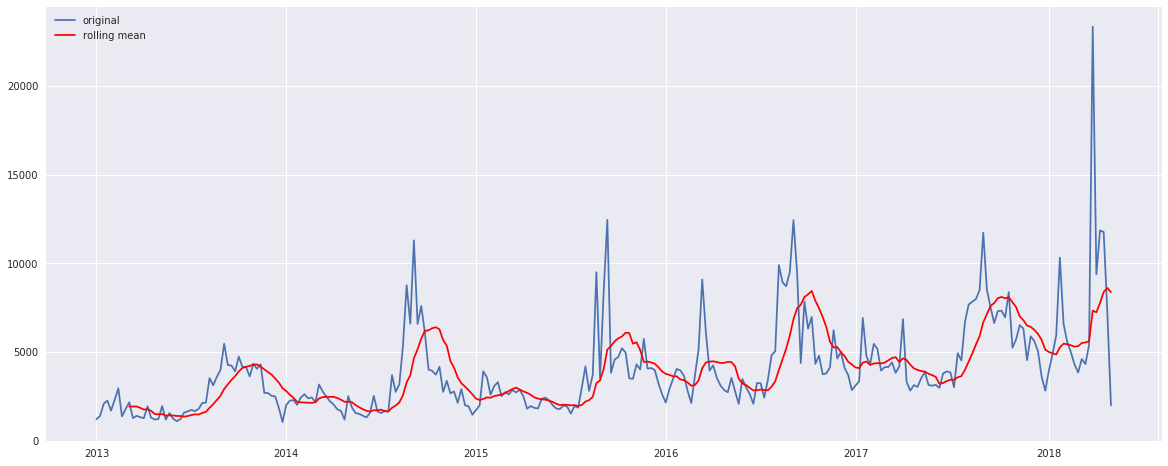

In [12]:
temp = pd.to_datetime(projects['Project Posted Date']).to_frame()
temp.loc[:,'count'] = 1
temp.sort_values(by='Project Posted Date',inplace=True)
temp.set_index(keys='Project Posted Date',inplace=True)
temp = temp.resample('W').count()
temp.set_index(temp.index.to_period(freq='W'),inplace=True)
ax1 = temp['count'].plot(figsize=(20,8))
mean = temp['count'].rolling(window=10).mean()
mean.plot(ax=ax1,color='r')
plt.legend(['original','rolling mean'])
plt.xlabel("")

From the above graph we learn there exists patterns that repeats every year. This is called the seasonality and play a part in statistical modeling. Note that in ARIMA model it's assumed that no seasonality exists. So we have to remove the seasonality to fit the ARIMA model. We do this by subtracting the shifted series from the original one.

Text(0.5,0,'')

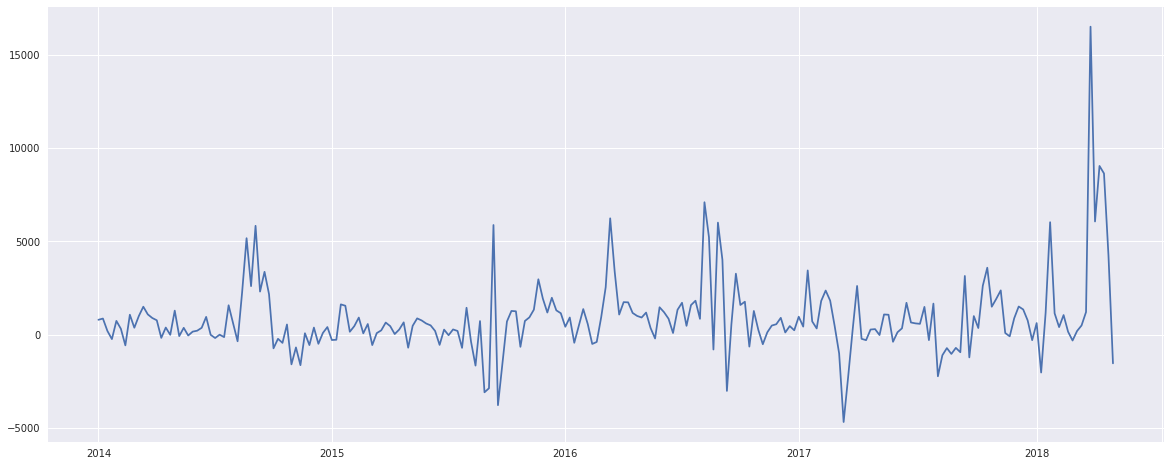

In [13]:
shifted = 52
temp.loc[:,'shifted_count'] = temp['count'].shift(shifted)
temp.loc[:,'diff_count'] = temp['count'].subtract(temp['shifted_count'])
temp.diff_count.plot(figsize=(20,8))
plt.xlabel("")

The difference now looks like a random series, that is, every point is drawn from some unknown distribution randomly. But we need more evidence to prove our assumption. Fortunately, statistics provides several tools to help decide the nonseasonality(stationarity) of a time series, one of which is <a href="https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test">augmented Dickey-Fuller test</a>, which is aim to test the stationarity of the time series. The more negative the test statistic is, the more likely the time series is stationary.

In [14]:
test = adfuller(temp.diff_count.dropna(), autolag='AIC')
output = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags','Number of Observations Used'])
for k,v in test[4].items():
    output['Critical Value (%s)'%k] = v
print(output)

Test Statistic                -6.024578e+00
p-value                        1.466304e-07
#Lags                          4.000000e+00
Number of Observations Used    2.220000e+02
Critical Value (5%)           -2.874649e+00
Critical Value (1%)           -3.460154e+00
Critical Value (10%)          -2.573757e+00
dtype: float64


The critical value (1%) is -2.87 and the test statistic is smaller than it, which means we can assume the target series is stationary with high probability. With this, we can start modeling the series with ARIMA model. Note that ARIMA model has the parameter triple (p,d,q). In order to get intuition of what these parameters should be, we first compute its <a href="https://en.wikipedia.org/wiki/Autocorrelation">autocorrelation(ACF)</a> and <a href="https://en.wikipedia.org/wiki/Partial_correlation">partial correlation(PACF)</a>. In short, auto correlation is the correlation with its lagged copy and partial correlation is the conditional correlation version.

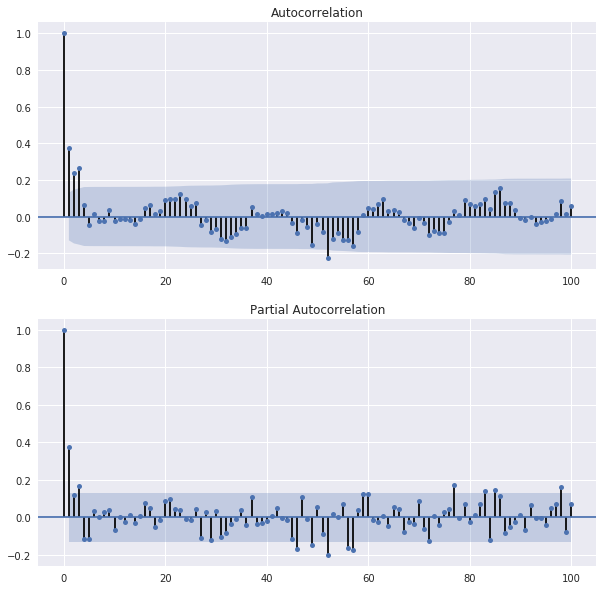

In [15]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(211)
fig = plot_acf(temp.diff_count.dropna(), lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(temp.diff_count.dropna(), lags=100, ax=ax2)

The x-axis of the above plots are degree of delay and the y-axis is the correlation value. First note that the highest value occurs when delay=0, which is obvious since any time series is fully correlated with itself. Second, the blue region represents the confidence interval, which shows any value outside the region are very likely to be true correlation. Third, we know significant values occur when delay=1 for both plots, which implies we may need to set p and q positive.  

Here we introduce <a href="https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method">Box-Jenkins method</a> to help us decide p and q. Since ACF looks sinusoidal and PACF has a spike at delay=1, we try (1,d,0)-ARIMA model. With some try and error we assume d=2. To validate the model we split the series into training and validation parts, and check how our model is performing on the validation set.

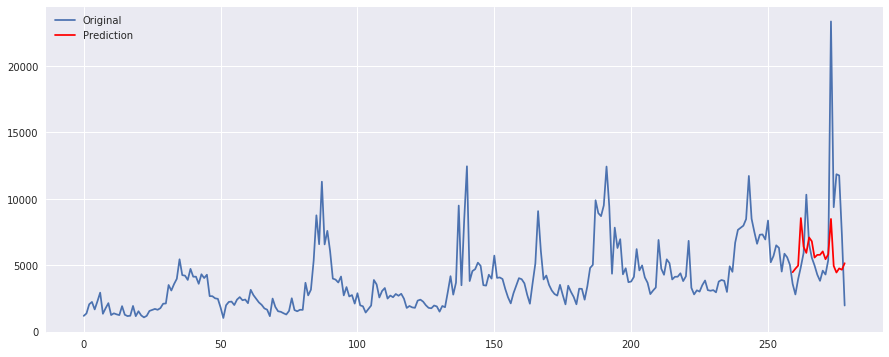

In [16]:
training = np.array(temp.diff_count.dropna())
test_len = 20
data = [x for x in training[:len(training)-test_len]]
predictions = []
for i in range(test_len):
    try:
        model = ARIMA(data, order=(1,2,0))
        ret = model.fit(disp=0)
        forecast = ret.forecast()
        prediction = forecast[0]
        predictions.append(prediction)
        data.append(testing[i])
    except:
        continue
        
# our prediction is shifted difference, we recover it by adding with the original series
values = temp['count'].values
for i in range(test_len):
    predictions[i] += values[len(temp)-shifted-test_len+i]
        
plt.figure(figsize=(15,6))
plt.plot(values)
plt.plot(pd.Series(predictions,index=range(len(temp)-test_len,len(temp))), color='red')
plt.legend(['Original','Prediction'])

It seems our model is quite accurate in validation.

### <a id='222'>2.2.2. Trend of Project Expiration Counts</a>

Here we try to analyze the time series of the number of expired projects with different approach. As usual, we need some visualization to help get intuition.

Text(0.5,0,'')

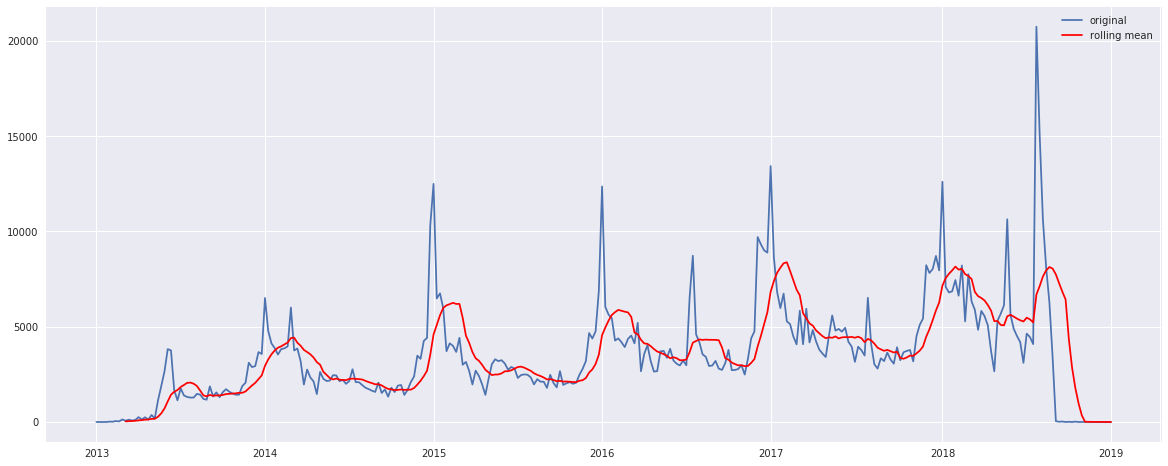

In [17]:
temp = pd.to_datetime(projects['Project Expiration Date']).to_frame()
temp.loc[:,'count'] = 1
temp.sort_values(by='Project Expiration Date',inplace=True)
temp.set_index(keys='Project Expiration Date',inplace=True)
temp = temp.resample('W').count()
temp.set_index(temp.index.to_period(freq='W'),inplace=True)
ax1 = temp['count'].plot(figsize=(20,8))
mean = temp['count'].rolling(window=10).mean()
mean.plot(ax=ax1,color='r')
plt.legend(['original','rolling mean'])
plt.xlabel("")

The tail is almost 0 and doesn't fit the rest of series. We try to get rid of it before analyzing.

Text(0.5,0,'')

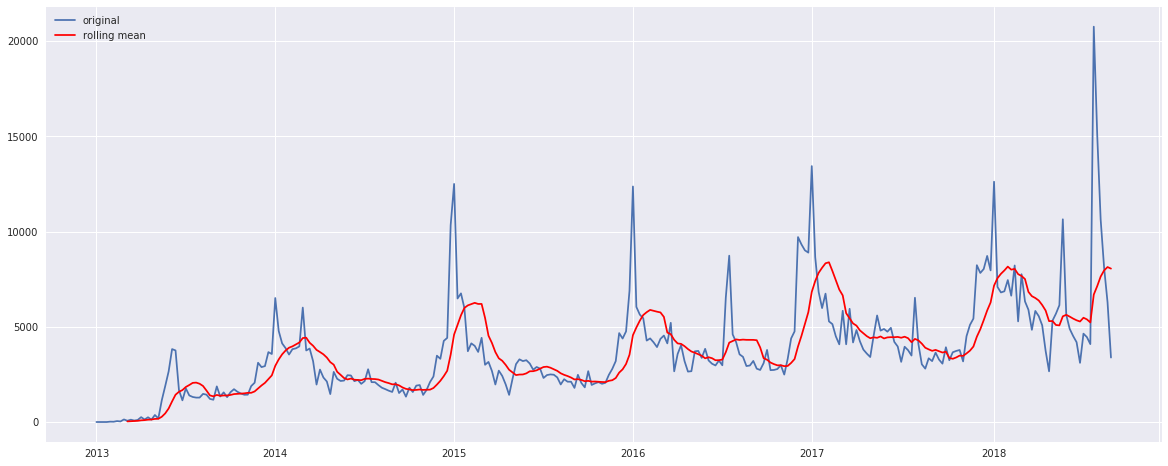

In [18]:
temp = temp.iloc[:-18,]
ax1 = temp['count'].plot(figsize=(20,8))
mean = temp['count'].rolling(window=10).mean()
mean.plot(ax=ax1,color='r')
plt.legend(['original','rolling mean'])
plt.xlabel("")

Let's analyze the seasonality and trend of this series. First we plot ACF and PACF of the original series.

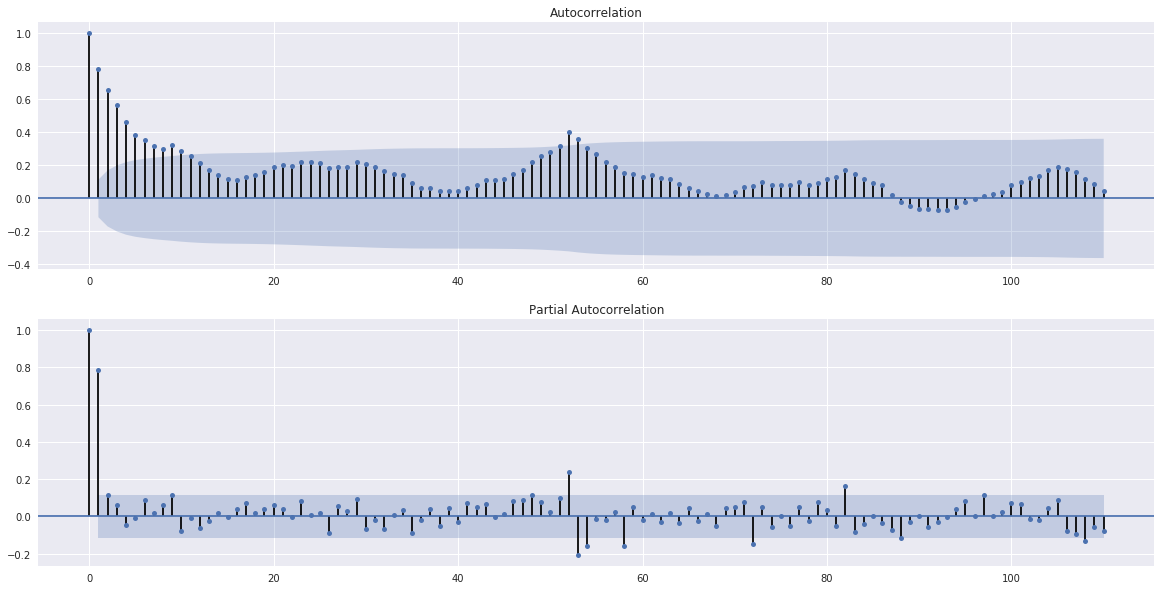

In [19]:
counts = temp['count'].values
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(211)
fig = plot_acf(counts, lags=110, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(counts, lags=110, ax=ax2)

There is a spike around delay=52, which is the evidence of existing seasonality. We remove the seasonality and plot the residue and its ACF and PACF.

Test Statistic                -7.891701e+00
p-value                        4.418778e-12
#Lags                          0.000000e+00
Number of Observations Used    2.430000e+02
Critical Value (5%)           -2.873509e+00
Critical Value (1%)           -3.457551e+00
Critical Value (10%)          -2.573148e+00
dtype: float64


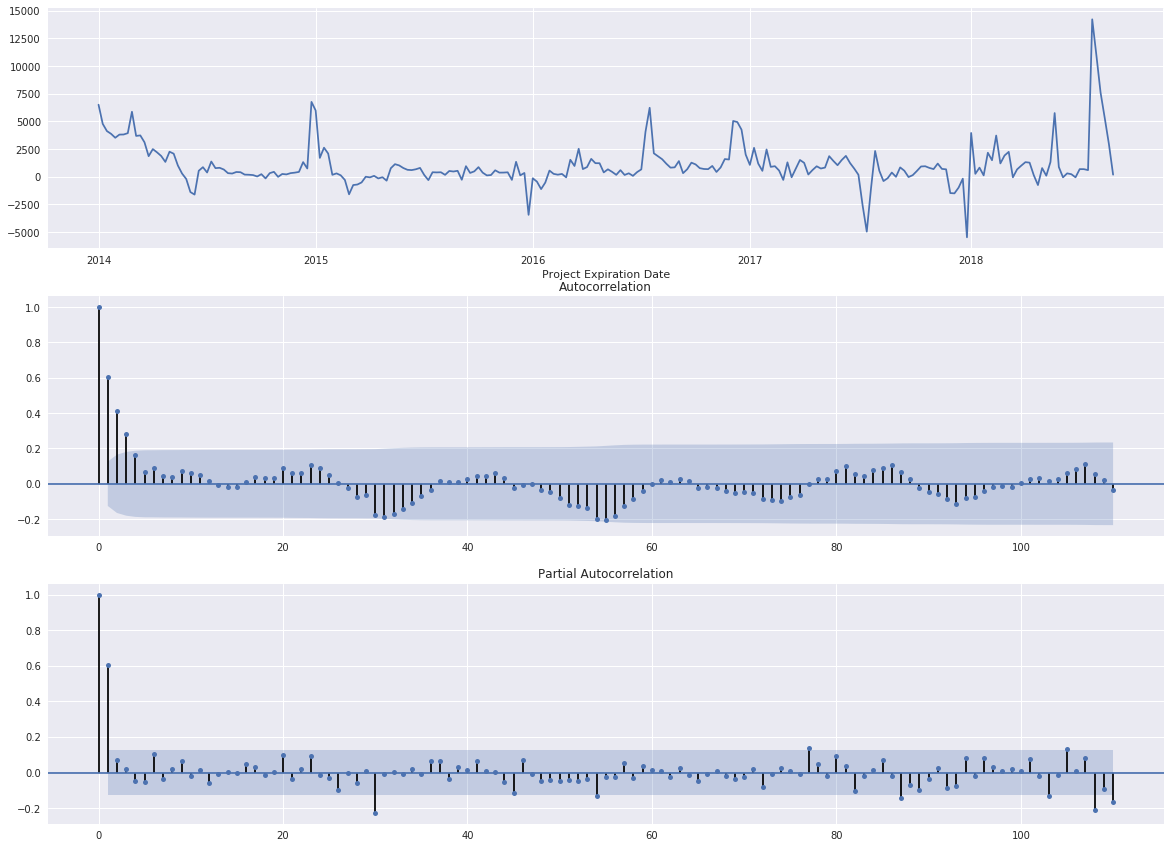

In [20]:
de_seasonality = temp['count'].subtract(temp['count'].shift(52)).dropna()
fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(311)
de_seasonality.plot(ax=ax1)
ax2 = fig.add_subplot(312)
fig = plot_acf(de_seasonality, lags=110, ax=ax2)
ax3 = fig.add_subplot(313)
fig = plot_pacf(de_seasonality, lags=110, ax=ax3)

# stationarity test
test = adfuller(de_seasonality, autolag='AIC')
output = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags','Number of Observations Used'])
for k,v in test[4].items():
    output['Critical Value (%s)'%k] = v
print(output)

From augmented Dickey-Fuller test we learned the de-seasoned series is stationary with high probability. So we can model the series now. Here we apply the function <a href="http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html">SARIMAX</a> from **statsmodels** to model our seasonal time series directly.

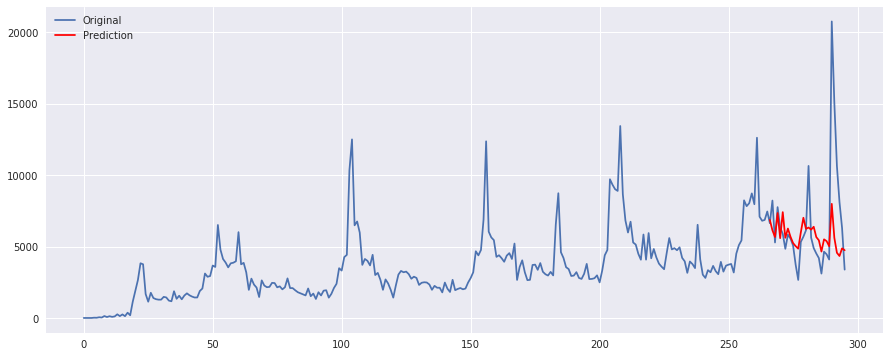

In [21]:
test_len = 30

# Since there is a spike at delay=1 for both ACF and PACF plot with de-seasoned series, we set order=(1,0,1)
# For the seasonal component, we try the most common seasonal_order=(0,1,1,period).
# You can use grid search to find best seasonal order.
model = SARIMAX(counts, trend='t', order=(1,0,1), seasonal_order=(0,1,1,52))
ret = model.fit()
predictions = ret.predict(start = len(counts)-test_len, end = len(counts)-1, dynamic = True)  
        
plt.figure(figsize=(15,6))
plt.plot(counts)
plt.plot(pd.Series(predictions,index=range(len(counts)-test_len,len(counts))), color='red')
plt.legend(['Original','Prediction'])

The above in-sample prediction depicts the trend roughly, although at some peaks the real data performs more extremely than the prediction does.

### <a id='223'>2.2.3. Trend of First Posted Project</a>

We do the same analysis as the same as previous sections.

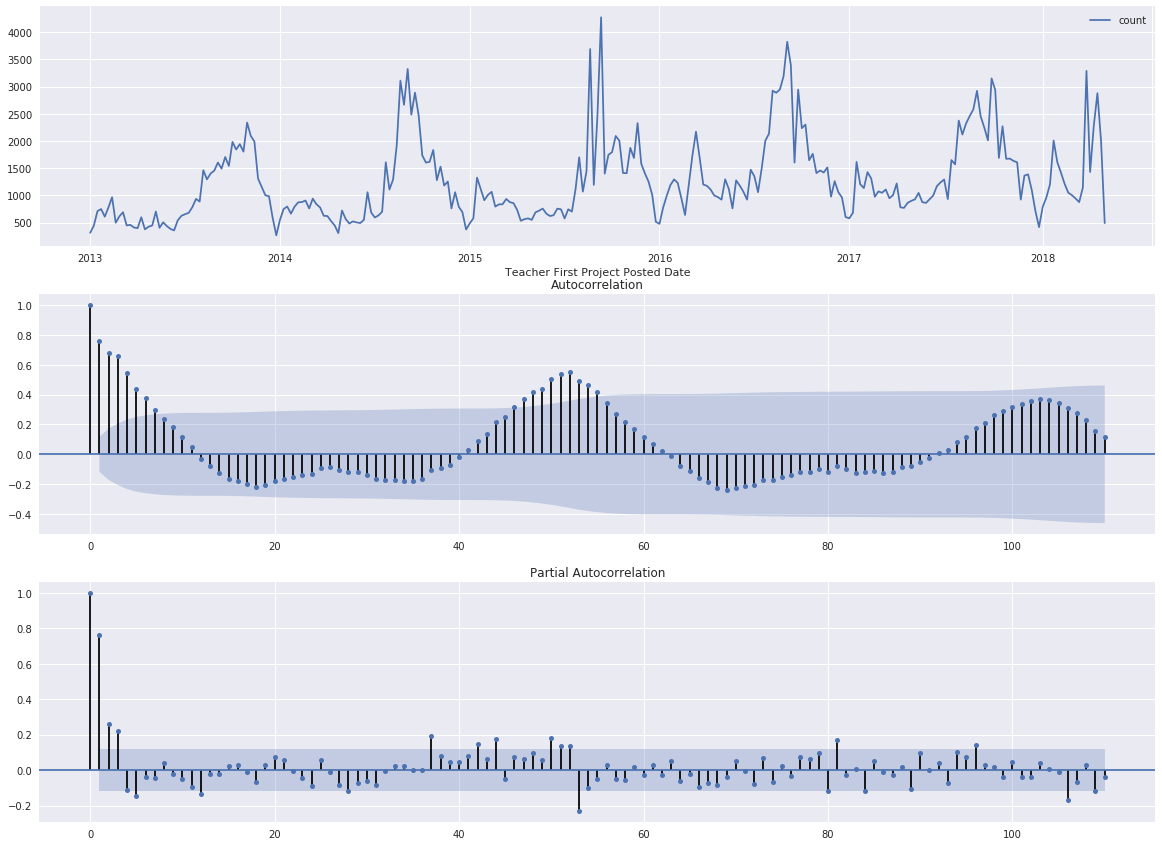

In [22]:
temp = pd.to_datetime(teachers['Teacher First Project Posted Date']).to_frame()
temp.loc[:,'count'] = 1
temp.sort_values(by='Teacher First Project Posted Date',inplace=True)
temp.set_index(keys='Teacher First Project Posted Date',inplace=True)
temp = temp.resample('W').count().dropna()
data = temp.loc['2013':,:]

# Plot the original time series, ACF and PACF
fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(311)
data.plot(ax=ax1)
ax2 = fig.add_subplot(312)
fig = plot_acf(data, lags=110, ax=ax2)
ax3 = fig.add_subplot(313)
fig = plot_pacf(data, lags=110, ax=ax3)

Test Statistic                  -3.973822
p-value                          0.001554
#Lags                           18.000000
Number of Observations Used    745.000000
Critical Value (5%)             -2.865427
Critical Value (1%)             -3.439158
Critical Value (10%)            -2.568840
dtype: float64


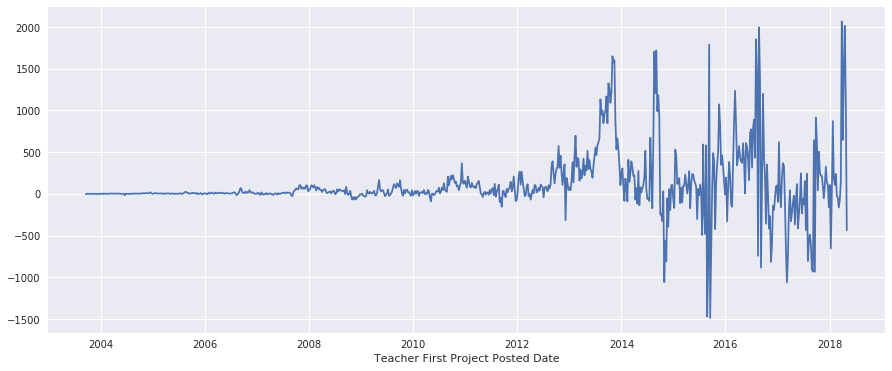

In [23]:
# de-season by taking shifted difference
de_seasonality = temp['count'].subtract(temp['count'].shift(52)).dropna()

# stationarity test
test = adfuller(de_seasonality, autolag='AIC')
output = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags','Number of Observations Used'])
for k,v in test[4].items():
    output['Critical Value (%s)'%k] = v
print(output)
plt.figure(figsize=(15,6))
de_seasonality.plot()

Although the test statistic is smaller than critival value (1%), but not so much. In this case we try to detrend by taking one more difference.

Test Statistic                -9.253002e+00
p-value                        1.474927e-15
#Lags                          1.800000e+01
Number of Observations Used    7.440000e+02
Critical Value (5%)           -2.865433e+00
Critical Value (1%)           -3.439170e+00
Critical Value (10%)          -2.568843e+00
dtype: float64


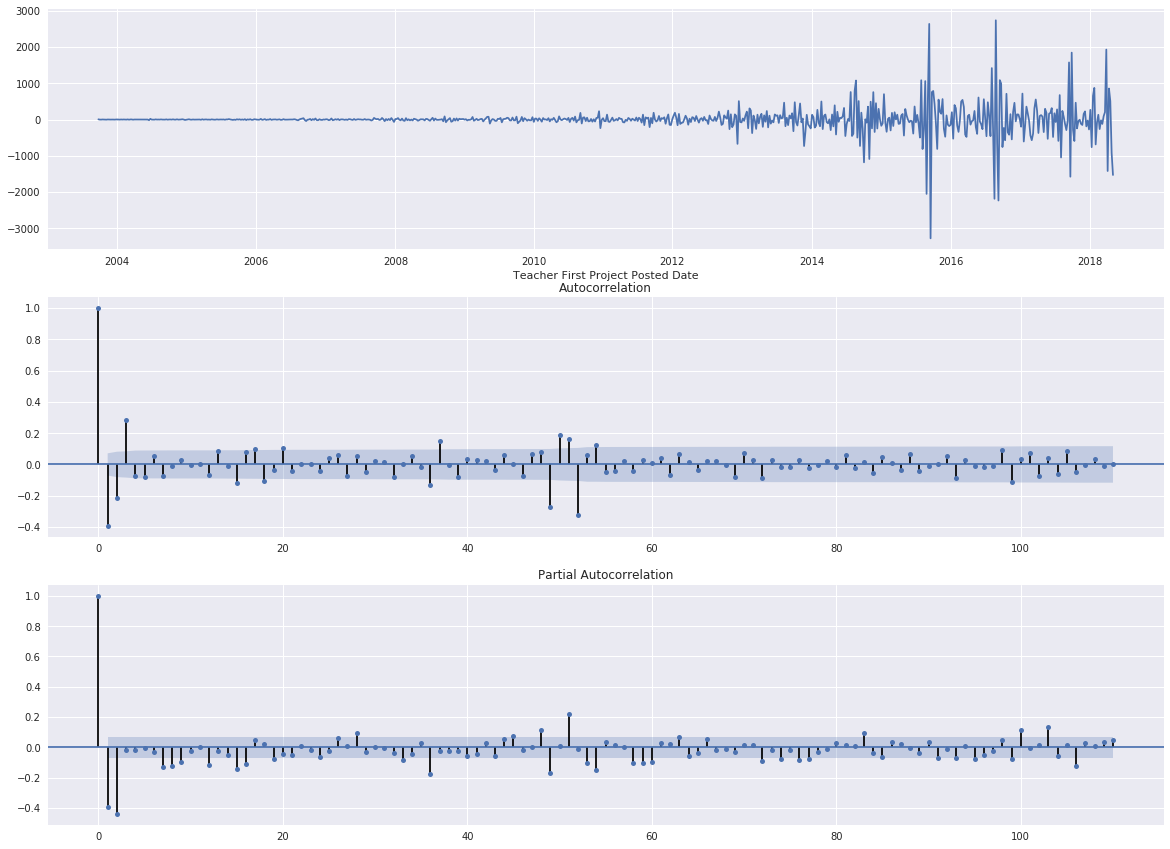

In [24]:
# detrend the sequence by taking one more diff
de_trend = de_seasonality.diff().dropna()
# stationarity test
test = adfuller(de_trend, autolag='AIC')
output = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags','Number of Observations Used'])
for k,v in test[4].items():
    output['Critical Value (%s)'%k] = v
print(output)
fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(311)
de_trend.plot(ax=ax1)
ax2 = fig.add_subplot(312)
fig = plot_acf(de_trend, lags=110, ax=ax2)
ax3 = fig.add_subplot(313)
fig = plot_pacf(de_trend, lags=110, ax=ax3)

The test statistic and p-value now look OK. From ACF and PACF we find (2,d,1) may be good parameters for nonseasonal components. Here we also fit the series into SARIMAX model.

/homes/li2566/.local/lib/python2.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



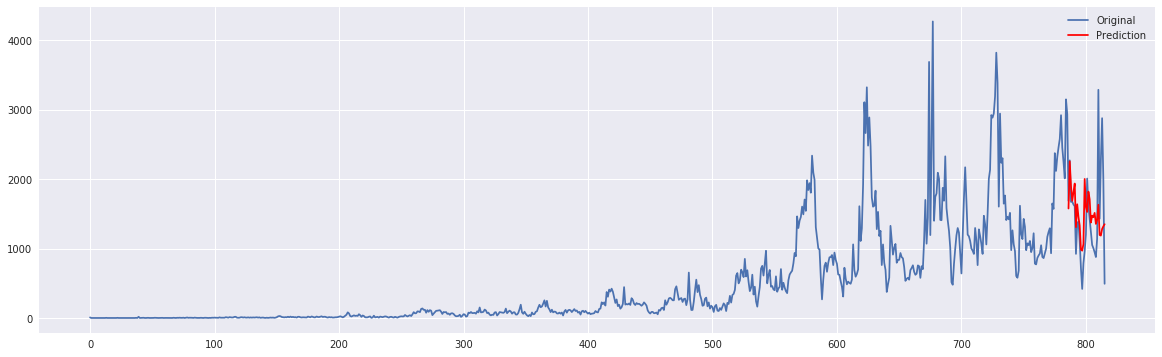

In [25]:
test_len = 30

# There is no significant spike after delay=2 in PACF and after delay=1 in ACF, so choose (2,d,1)
model = SARIMAX(temp['count'].values, trend='t', order=(2,2,1), seasonal_order=(0,1,0,52))
ret = model.fit()
predictions = ret.predict(start = len(temp)-test_len, end = len(temp)-1, dynamic = True)  
        
plt.figure(figsize=(20,6))
plt.plot(temp['count'].values)
plt.plot(pd.Series(predictions,index=range(len(temp)-test_len,len(temp))), color='red')
plt.legend(['Original','Prediction'])

The in-sample prediction seems quite accurate initially, then start deviating in the middle.

### <a id='224'>2.2.4. Trend of Donation Amounts</a>

Here we apply LSTM model to model the time series. 

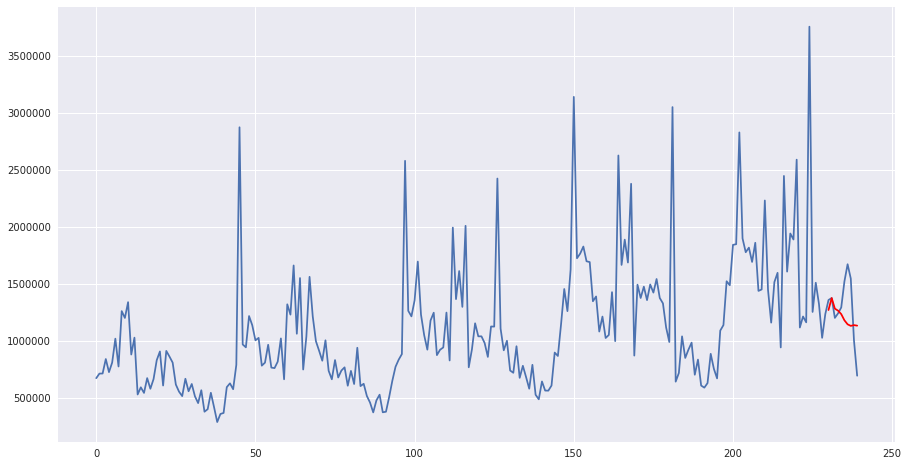

In [26]:
# parameters
time_step = 52
batch_size = 1
test_size = 10
epochs = 100

# create dataset for LSTM
data = donations.loc[:,['Donation Amount','Donation Received Date']]
data.loc[:,'Donation Received Date'] = pd.to_datetime(data.loc[:,'Donation Received Date'])
data.sort_values(by='Donation Received Date',inplace=True)
data.set_index(keys='Donation Received Date',inplace=True)
data = data.resample('W').sum()
data.set_index(data.index.to_period(freq='W'),inplace=True)

X, y = [], []
temp = data.values
scaler = MinMaxScaler(feature_range=(0, 1))
temp = scaler.fit_transform(temp)
for i in range(len(temp)-time_step):
    X.append(temp[i:(i+time_step),0])
    y.append(temp[(i+time_step),0])
X,y = np.array(X), np.array(y)
X_train, X_test = X[:(X.shape[0]-test_size),:], X[(X.shape[0]-test_size):,:]
y_train, y_test = y[:(y.shape[0]-test_size)], y[(y.shape[0]-test_size):]
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

# build LSTM model
model = Sequential()
model.add(LSTM(12,
               batch_input_shape = (batch_size,X_train.shape[1],1),
               stateful = True))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam')

# fitting model
for i in range(epochs):
    model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=0, shuffle=False)
    model.reset_states()
    
# forecast
prediction = model.predict(X_test, batch_size)
prediction = scaler.inverse_transform(prediction)
y = scaler.inverse_transform([y])
y = y.flatten()

# plot prediction
plt.figure(figsize=(15,8))
plt.plot(y)
plt.plot([None]*(len(y)-test_size) + [x[0] for x in prediction],color='red')